# Практическая работа 2
## Выполнил Гневнов А.Е., ИВТ 2.1
### Сегментировать студентов на основе их ответов в анкете, касающейся различных аспектов учебного процесса
### Понимание бизнес-задачи (Business Understanding)
 **Практическое применение:**
 - Адаптация форматов учебных материалов
 - Оптимизация образовательных платформ
 - Разработка целевых программ поддержки
 - Улучшение коммуникации преподавателей со студентами  
**Ожидаемые результаты:** 3-5 интерпретируемых кластеров с четкими профилями

### 2. Понимание данных (Data Understanding)

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import umap.umap_ as umap
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.impute import SimpleImputer

#### Загрузка данных

In [4]:
try:
    df = pd.read_excel('data/dlia studentov.xlsx')
    print("Файл успешно загружен")
except FileNotFoundError:
    print("Ошибка: Файл не найден. Убедитесь в правильности пути")
    # Создание демо-датасета для примера
    data = {
        'Использует Moodle': np.random.choice([0,1], 100),
        'Предпочитает видео': np.random.choice([0,1], 100),
        'Любит групповую работу': np.random.choice([0,1], 100),
        'Факультет': np.random.choice(['Экономика', 'Информатика', 'Лингвистика'], 100)
    }
    df = pd.DataFrame(data)
    
print(f"Размер данных: {df.shape}")
df.head()

Файл успешно загружен
Размер данных: (711, 23)


,ID,Время создания,На каком факультете/в каком институте Вы обучаетесь?,"Какая платформа для обучения дисциплине ""ИНФОКОММУНИКАЦИОННЫЕ ТЕХНОЛОГИИ"" использовалась?","Был ли предусмотрен фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить)","Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?","Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов)","Необходим ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов) в электронном курсе?","Материалы, представленные для практического задания, были в разных форматах (например, одновременно и текстовый, и видео)?","Необходимо ли представлять материалы для практического задания в разных форматах (например, одновременно и текстовый, и видео)?",...,Необходим ли встроенный электронный журнал прогресса выполненных работ студентом?,Были ли встроенны в электронный курс видеолекции?,Необходимо ли встраивать в электронный курс видеолекции?,Были ли встроенные в электронный курс тесты по материалом видео лекций?,Была ли предусмотрена рефлексия (отзыв) после выполнения каждого практического задания?,Необходима ли рефлексия (отзыв) после выполнения каждого практического задания?,Была ли предусмотрена рефлексия (отзыв) после завершения работы по дисциплине?,Необходима ли рефлексия (отзыв) после завершения работы по дисциплине?,Было ли организовано взаимодействие с преподавателями посредством мессенджеров?,Необходимо ли организовывать взаимодействие с преподавателями посредством мессенджеров?
0,1408291245,2023-06-07 20:41:17,институт истории и социальных наук,Moodle,нет,нет,нет,нет,да,нет,...,да,да,нет,да,нет,да,нет,да,да,да
1,1405883214,2023-06-05 09:02:21,институт педагогики,Moodle,да,да,нет,да,нет,да,...,да,да,да,да,да,да,да,да,да,да
2,1405869646,2023-06-05 08:44:38,институт педагогики,Moodle,да,да,да,да,да,да,...,да,да,да,да,да,да,да,да,да,да
3,1405856131,2023-06-05 08:26:39,институт педагогики,Moodle,да,да,нет,нет,да,да,...,да,да,да,да,да,да,да,да,да,да
4,1405854542,2023-06-05 08:24:47,институт педагогики,Moodle,да,да,нет,нет,да,да,...,да,да,да,да,нет,нет,да,нет,нет,да


#### Первичный анализ


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 23 columns):
 #   Column                                                                                                                                      Non-Null Count  Dtype 
---  ------                                                                                                                                      --------------  ----- 
 0   ID                                                                                                                                          711 non-null    int64 
 1   Время создания                                                                                                                              711 non-null    object
 2   На каком факультете/в каком институте Вы обучаетесь?                                                                                        711 non-null    object
 3   Какая платформа для обучения

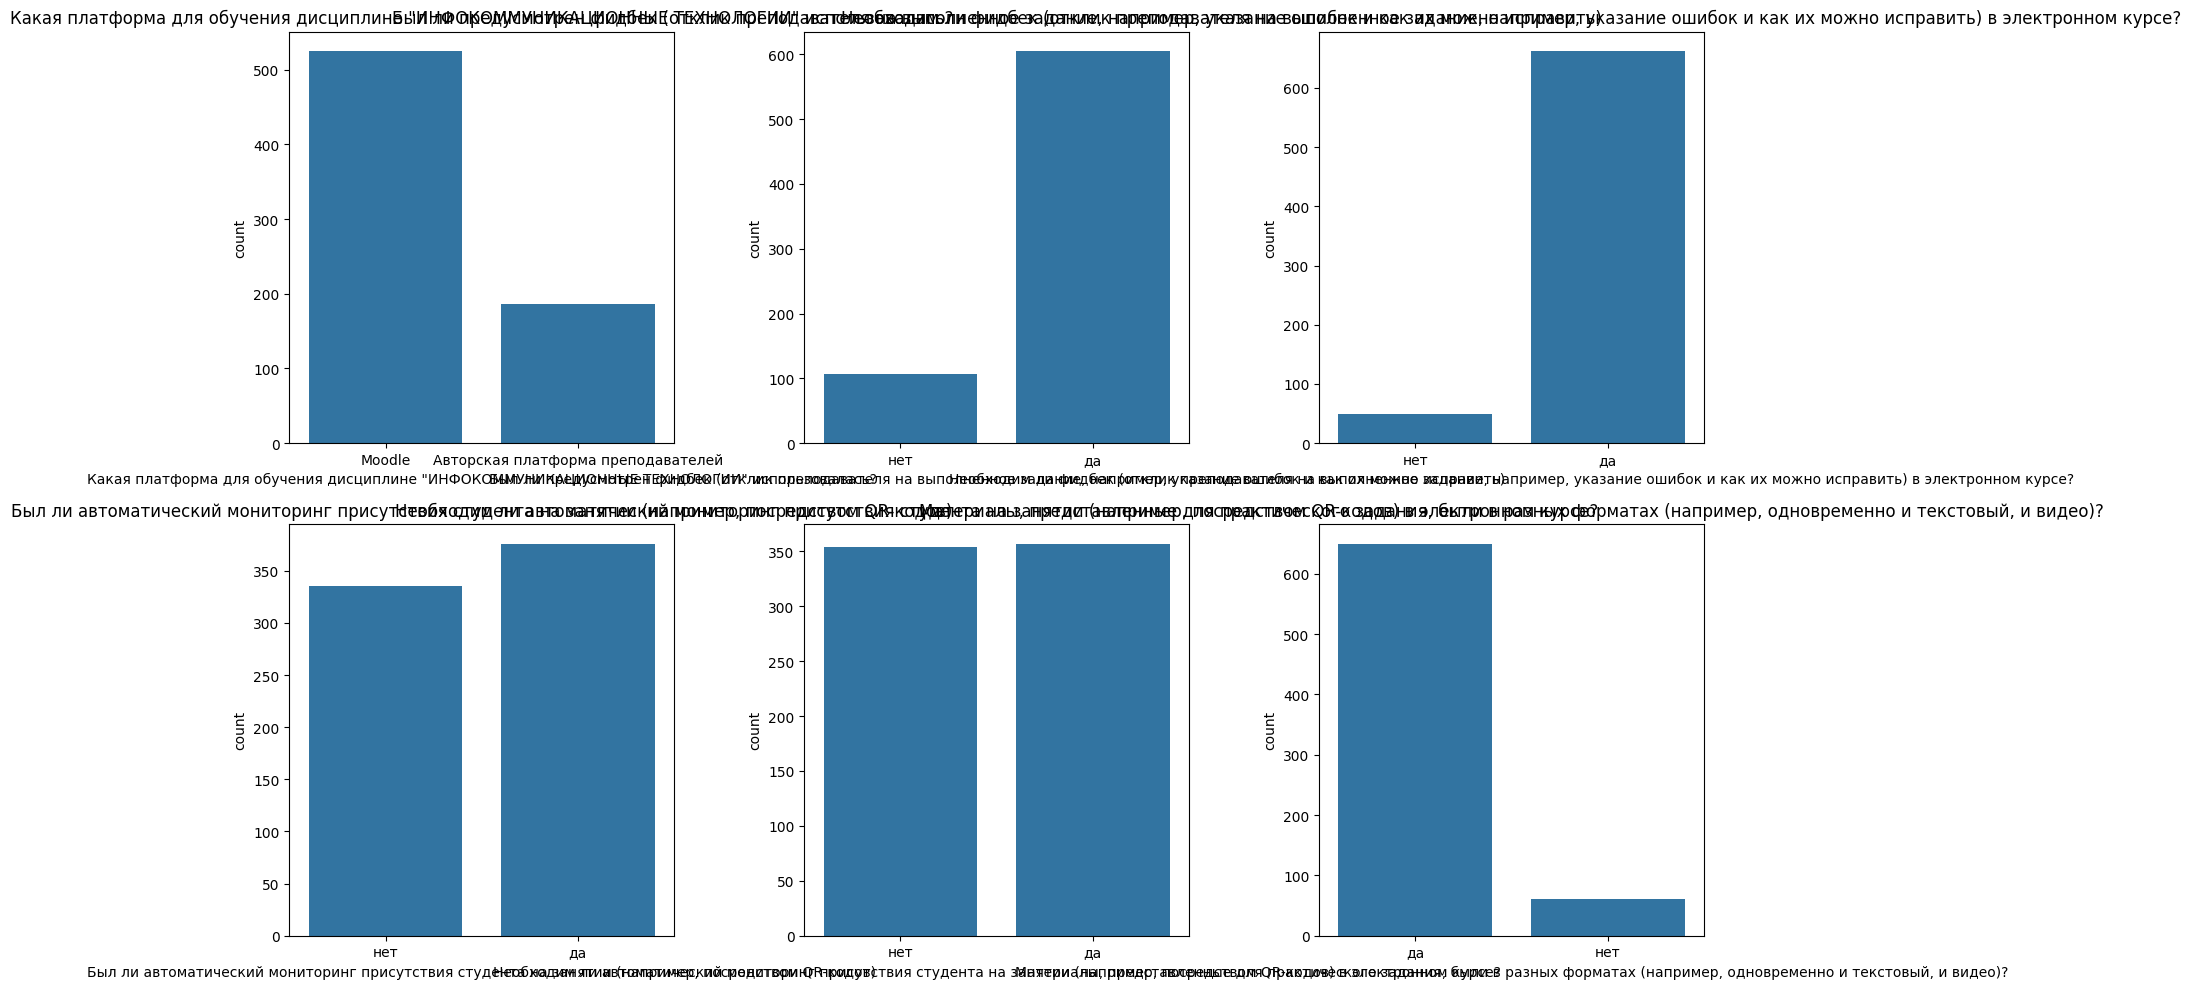

In [5]:
# Проверка типов данных и пропусков
print("\nИнформация о данных:")
df.info()

print("\nПропущенные значения:")
print(df.isnull().sum())

# Анализ распределения бинарных признаков
binary_cols = [col for col in df.columns if df[col].nunique() == 2]
print(f"\nБинарные признаки ({len(binary_cols)}): {binary_cols}")

plt.figure(figsize=(15, 10))
for i, col in enumerate(binary_cols[:6]):
    plt.subplot(2, 3, i+1)
    sns.countplot(x=col, data=df)
    plt.title(col)
plt.tight_layout()

#### Анализ связей (Phi-коэффициент)

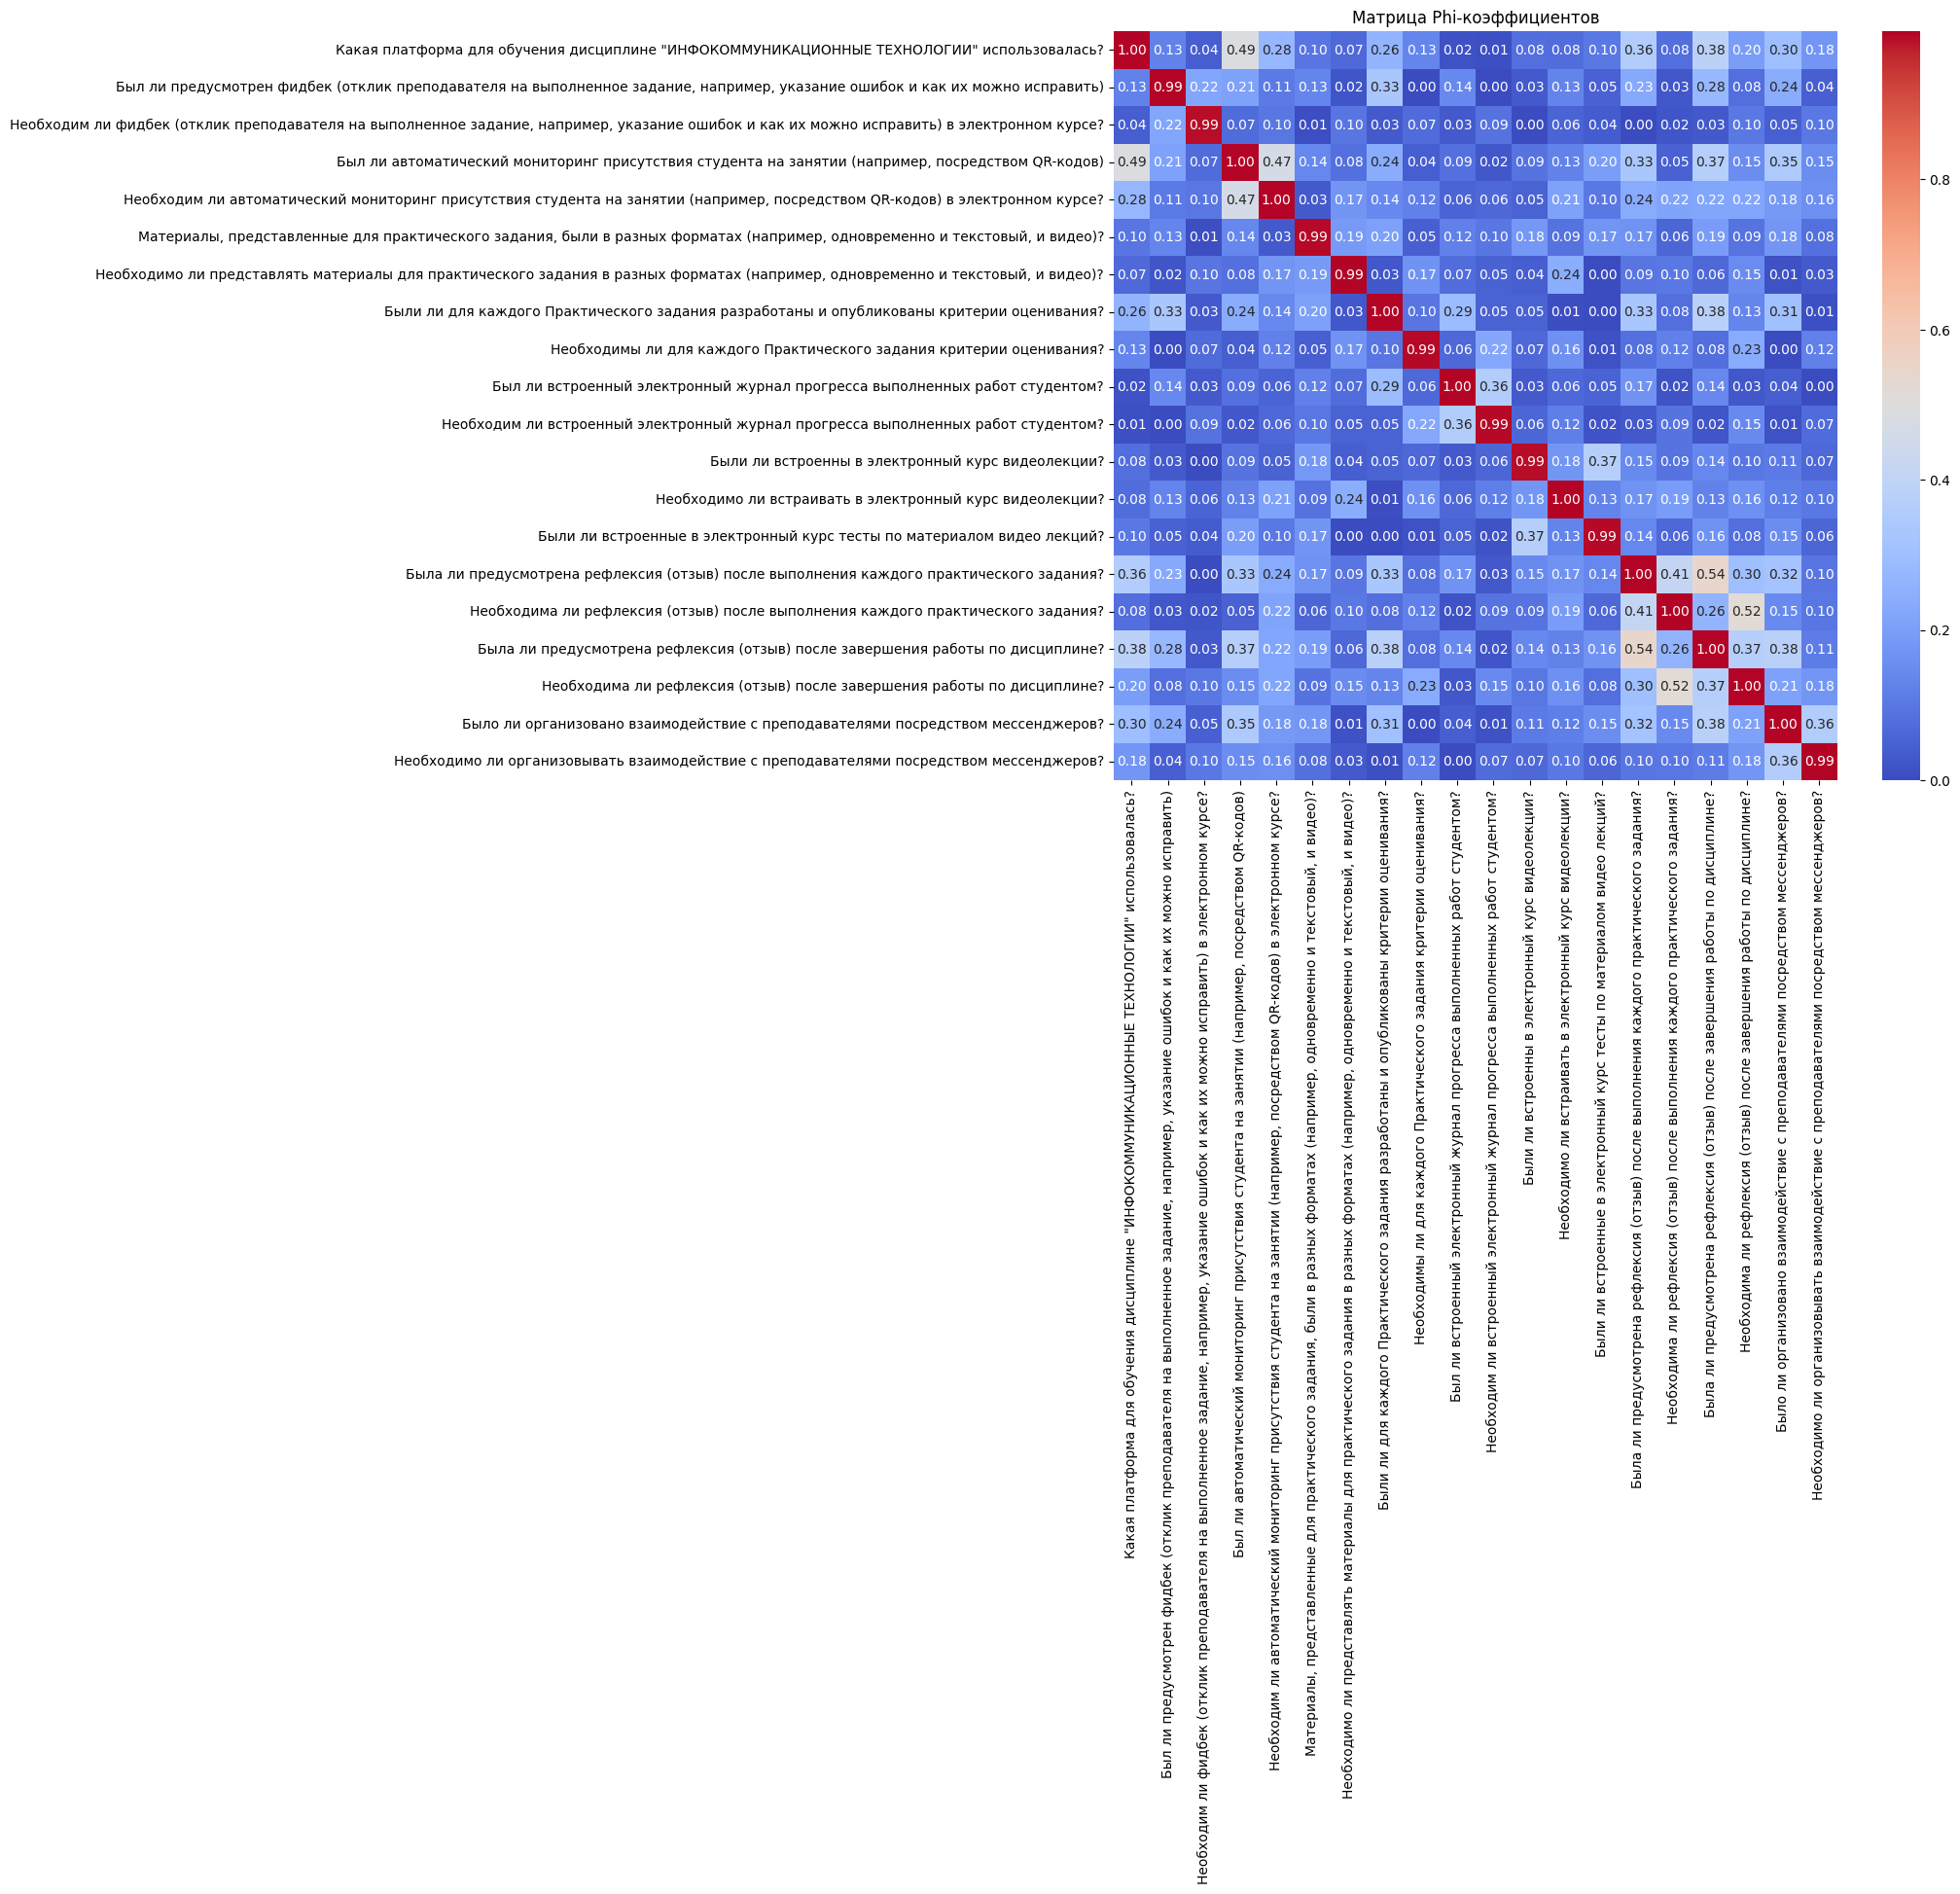

In [6]:
def phi_coefficient(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / n)

phi_matrix = pd.DataFrame(index=binary_cols, columns=binary_cols)
for col1 in binary_cols:
    for col2 in binary_cols:
        phi_matrix.loc[col1, col2] = phi_coefficient(df[col1], df[col2])

plt.figure(figsize=(12, 10))
sns.heatmap(phi_matrix.astype(float), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Матрица Phi-коэффициентов")
plt.show()

### 3. Подготовка данных (Data Preparation)


#### Обработка пропусков

In [45]:
df_filled = df.copy()

#### Кодирование бинарных признаков

In [46]:
for col in binary_cols:
    df_filled[col] = df_filled[col].map({'да': 1, 'нет': 0})  # кодируем сразу
    df_filled[col] = df_filled[col].fillna(0)  # заполняем пропуски нулями

#### Выделение признаков для кластеризации

In [47]:
features = df_filled[binary_cols]


#### Снижение размерности с UMAP

In [48]:
umap_2d = umap.UMAP(n_components=2, random_state=42)
umap_3d = umap.UMAP(n_components=3, random_state=42)

features_umap_2d = umap_2d.fit_transform(features)
features_umap_3d = umap_3d.fit_transform(features)

c:\Users\gnevn\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gnevn\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\gnevn\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gnevn\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


#### Визуализация UMAP

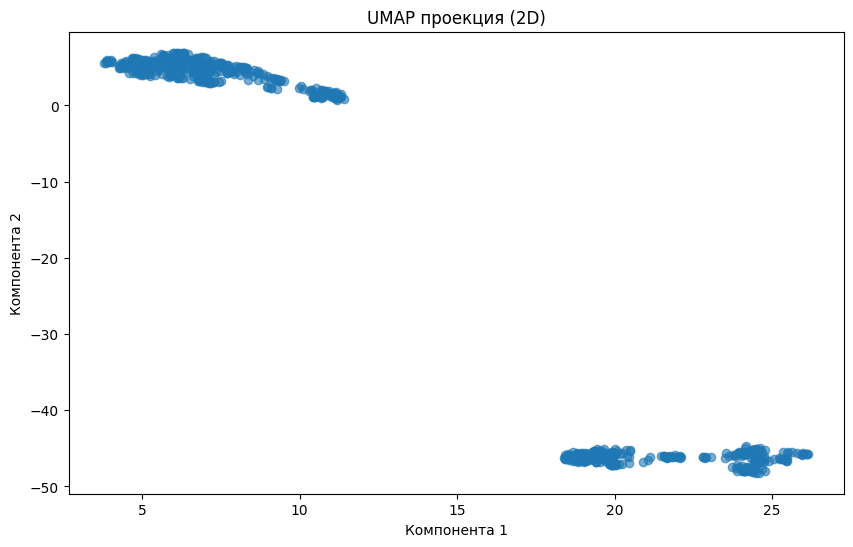

In [49]:
plt.figure(figsize=(10, 6))
plt.scatter(features_umap_2d[:, 0], features_umap_2d[:, 1], alpha=0.6)
plt.title("UMAP проекция (2D)")
plt.xlabel("Компонента 1")
plt.ylabel("Компонента 2")
plt.show()

### 4. Моделирование (Modeling)

#### Определение оптимального числа кластеров (метод локтя)

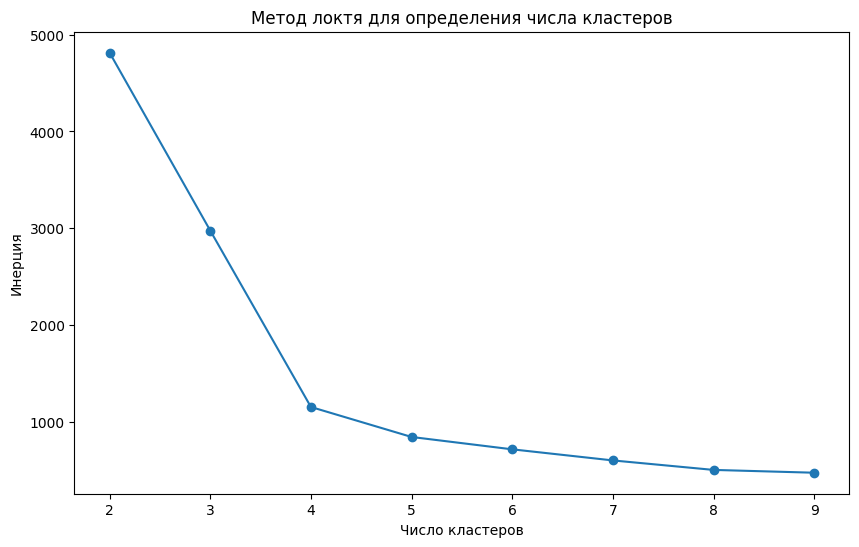

In [50]:
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_umap_2d)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), inertia, marker='o')
plt.xlabel("Число кластеров")
plt.ylabel("Инерция")
plt.title("Метод локтя для определения числа кластеров")
plt.show()

#### Выбор алгоритмов кластеризации

In [51]:
algorithms = {
    "KMeans": KMeans(n_clusters=4, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=4),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5),
    "GMM": GaussianMixture(n_components=4, random_state=42)
}

#### Применение алгоритмов

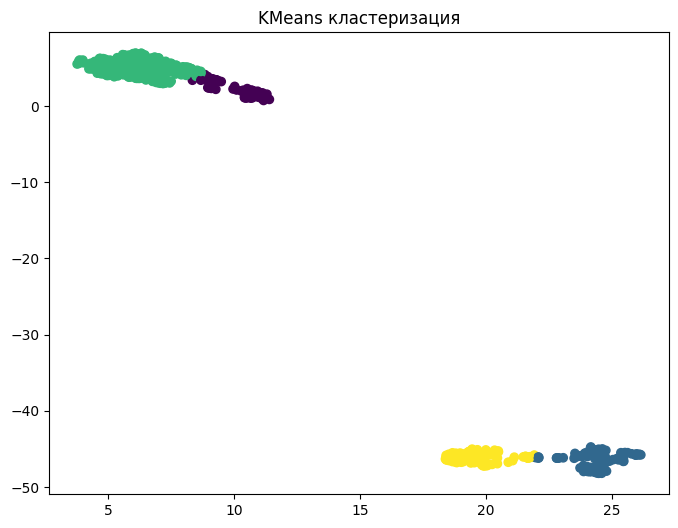

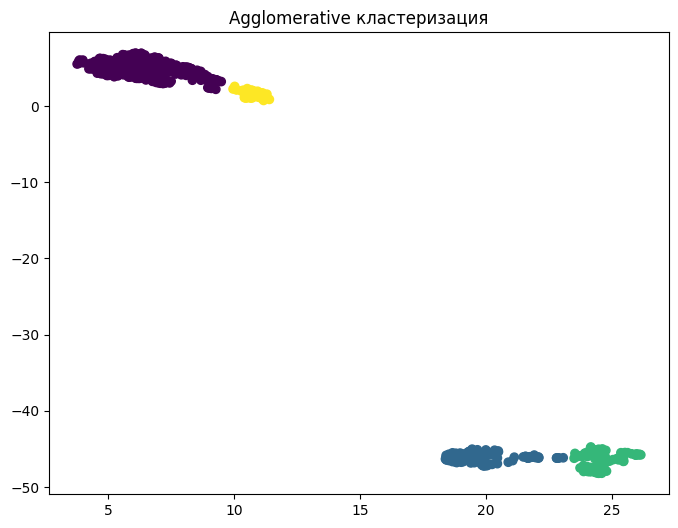

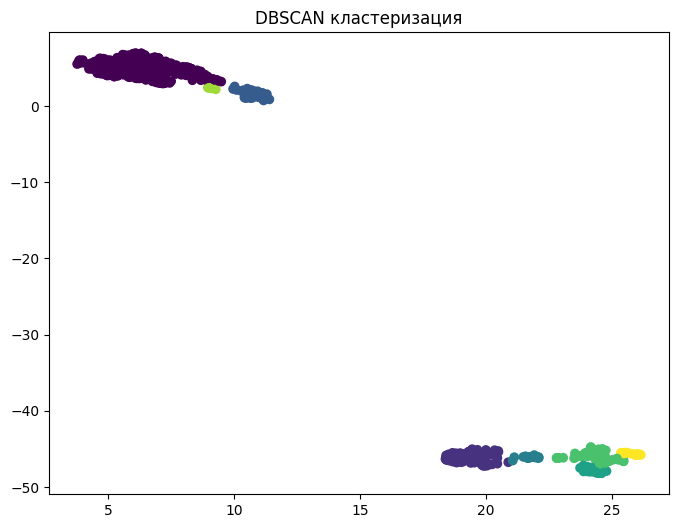

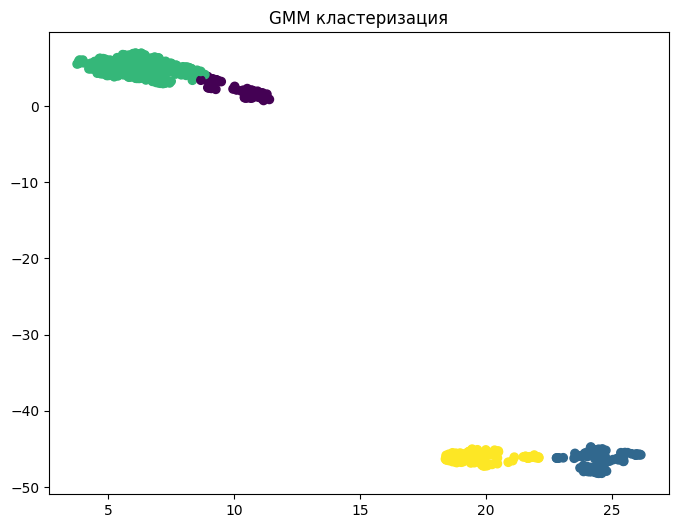

In [52]:
# Применение алгоритмов
results = {}
for name, algo in algorithms.items():
    if name == "GMM":
        clusters = algo.fit_predict(features_umap_2d)
    else:
        clusters = algo.fit_predict(features_umap_2d)
    results[name] = clusters
    
    # Визуализация
    plt.figure(figsize=(8, 6))
    plt.scatter(features_umap_2d[:,0], features_umap_2d[:,1], c=clusters, cmap='viridis')
    plt.title(f"{name} кластеризация")
    plt.show()

### 5. Оценка (Evaluation)


In [53]:
evaluation = pd.DataFrame(columns=['Алгоритм', 'Silhouette', 'Davies-Bouldin'])

for name, clusters in results.items():
    if len(np.unique(clusters)) > 1:
        sil_score = silhouette_score(features_umap_2d, clusters)
        db_score = davies_bouldin_score(features_umap_2d, clusters)
        new_row = pd.DataFrame([{
            'Алгоритм': name,
            'Silhouette': sil_score,
            'Davies-Bouldin': db_score
        }])
        evaluation = pd.concat([evaluation, new_row], ignore_index=True)

print("Результаты оценки кластеризации:")
print(evaluation)


Результаты оценки кластеризации:
        Алгоритм  Silhouette  Davies-Bouldin
0         KMeans    0.675482        0.441980
1  Agglomerative    0.665042        0.386154
2         DBSCAN    0.502846        0.470003
3            GMM    0.677624        0.435324


C:\Users\gnevn\AppData\Local\Temp\ipykernel_22132\3538467525.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  evaluation = pd.concat([evaluation, new_row], ignore_index=True)


### 6. Визуализация и представление результатов

#### Выбираем лучший алгоритм, в шаге 5 видно, что это *KMeans*

In [55]:
best_model = KMeans(n_clusters=4, random_state=42)
df_filled['Cluster'] = best_model.fit_predict(features_umap_2d)

#### Радарные диаграммы

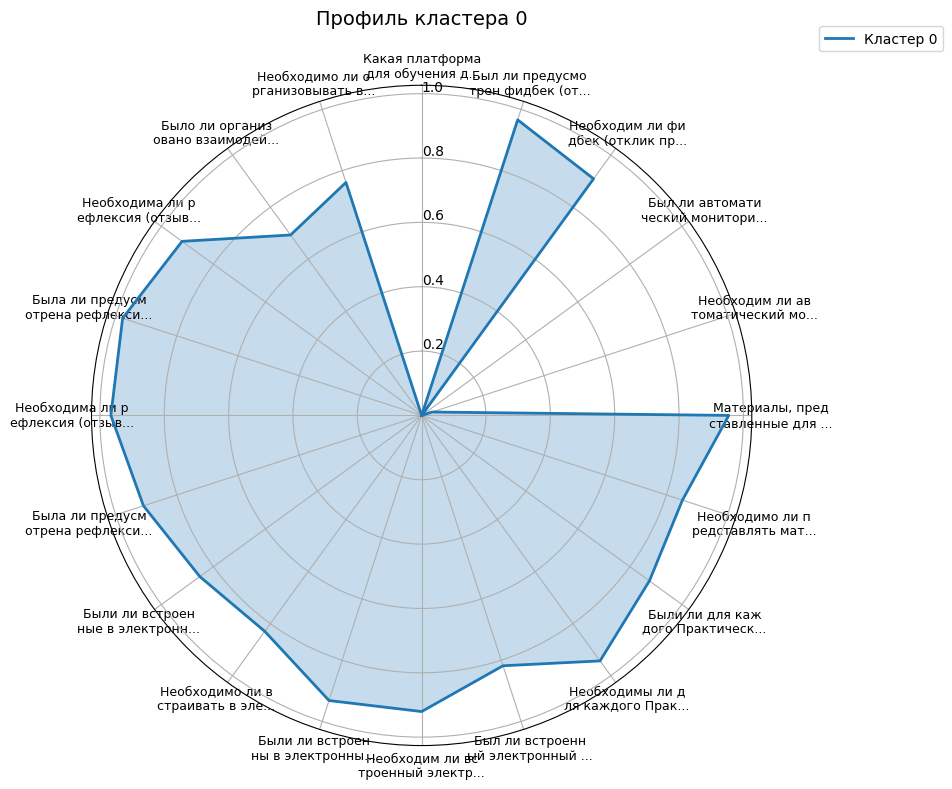

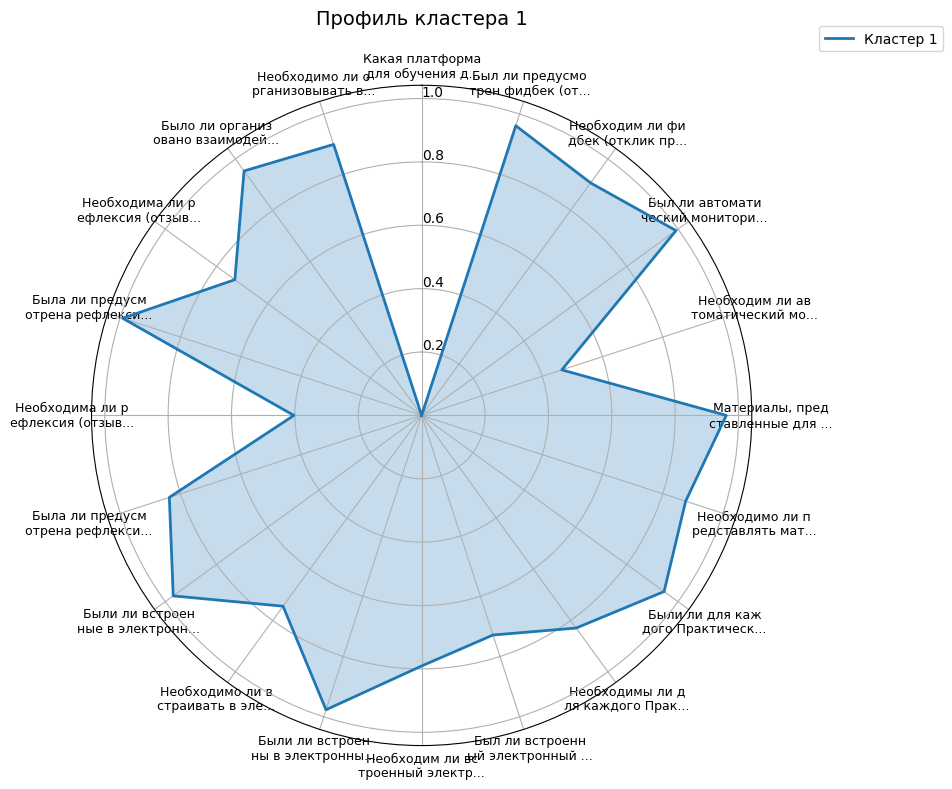

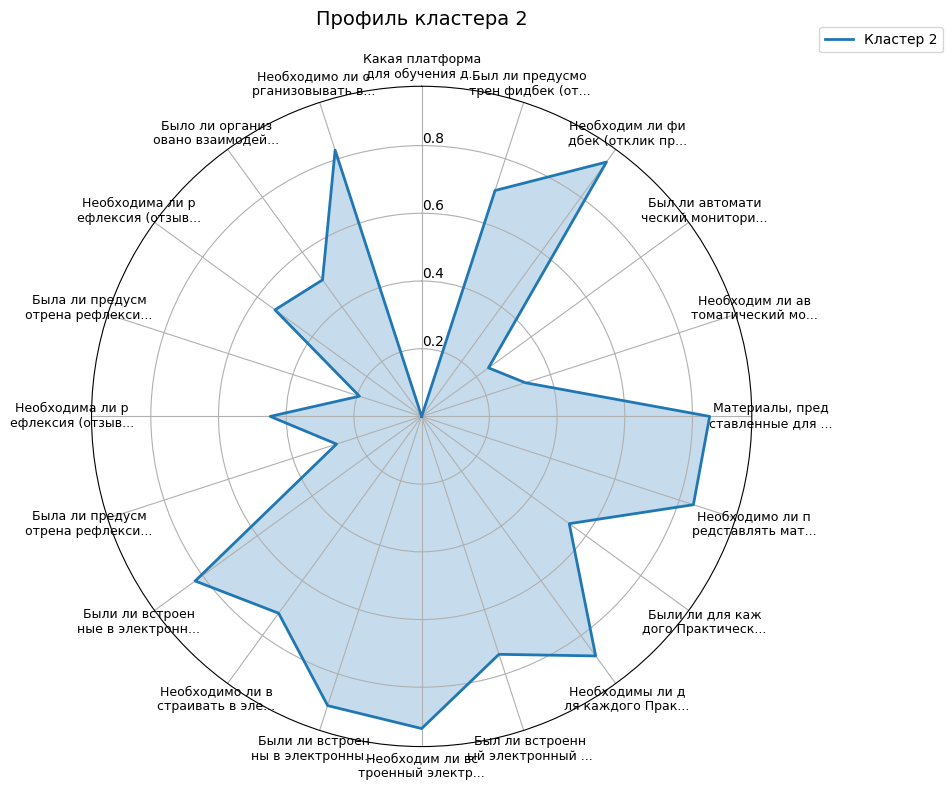

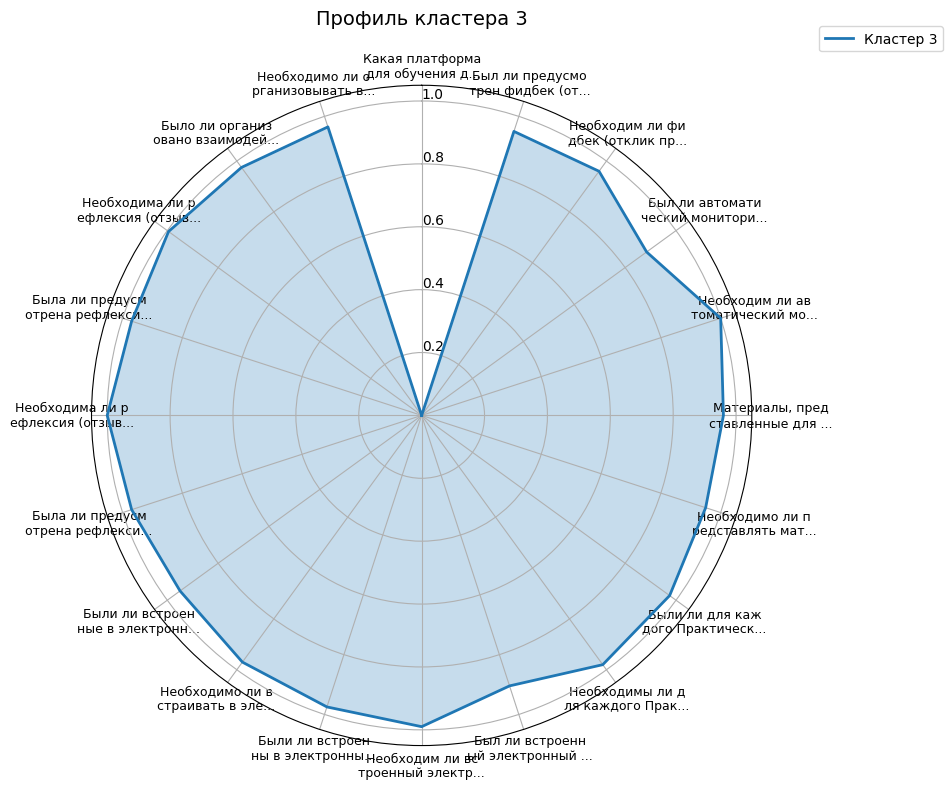

In [72]:
# Радарные диаграммы (улучшенная версия)
cluster_profiles = df_filled.groupby('Cluster')[binary_cols].mean()

# Определяем количество кластеров
n_clusters = len(cluster_profiles)

# Создаем отдельную фигуру для каждого кластера
for cluster in cluster_profiles.index:
    plt.figure(figsize=(10, 8))
    ax = plt.subplot(111, polar=True)
    
    # Подготовка данных
    values = cluster_profiles.loc[cluster].tolist()
    angles = np.linspace(0, 2*np.pi, len(binary_cols), endpoint=False).tolist()
    
    # Замыкаем диаграмму
    values += values[:1]
    angles += angles[:1]
    
    # Рисуем диаграмму
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Кластер {cluster}')
    ax.fill(angles, values, alpha=0.25)
    
    # Настройка осей
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    
    # Улучшение подписей
    xticks = angles[:-1]
    ax.set_xticks(xticks)
    
    # Сокращаем длинные названия и переносим слова
    short_labels = [label[:15] + '\n' + label[15:30] + (label[30:] and '...') 
                   for label in binary_cols]
    
    ax.set_xticklabels(short_labels, fontsize=9, va='center', ha='center')
    
    # Добавляем заголовок и легенду
    plt.title(f'Профиль кластера {cluster}', size=14, pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    
    # Сохраняем каждый кластер отдельно
    plt.tight_layout()
    plt.show()

#### Распределение по факультетам

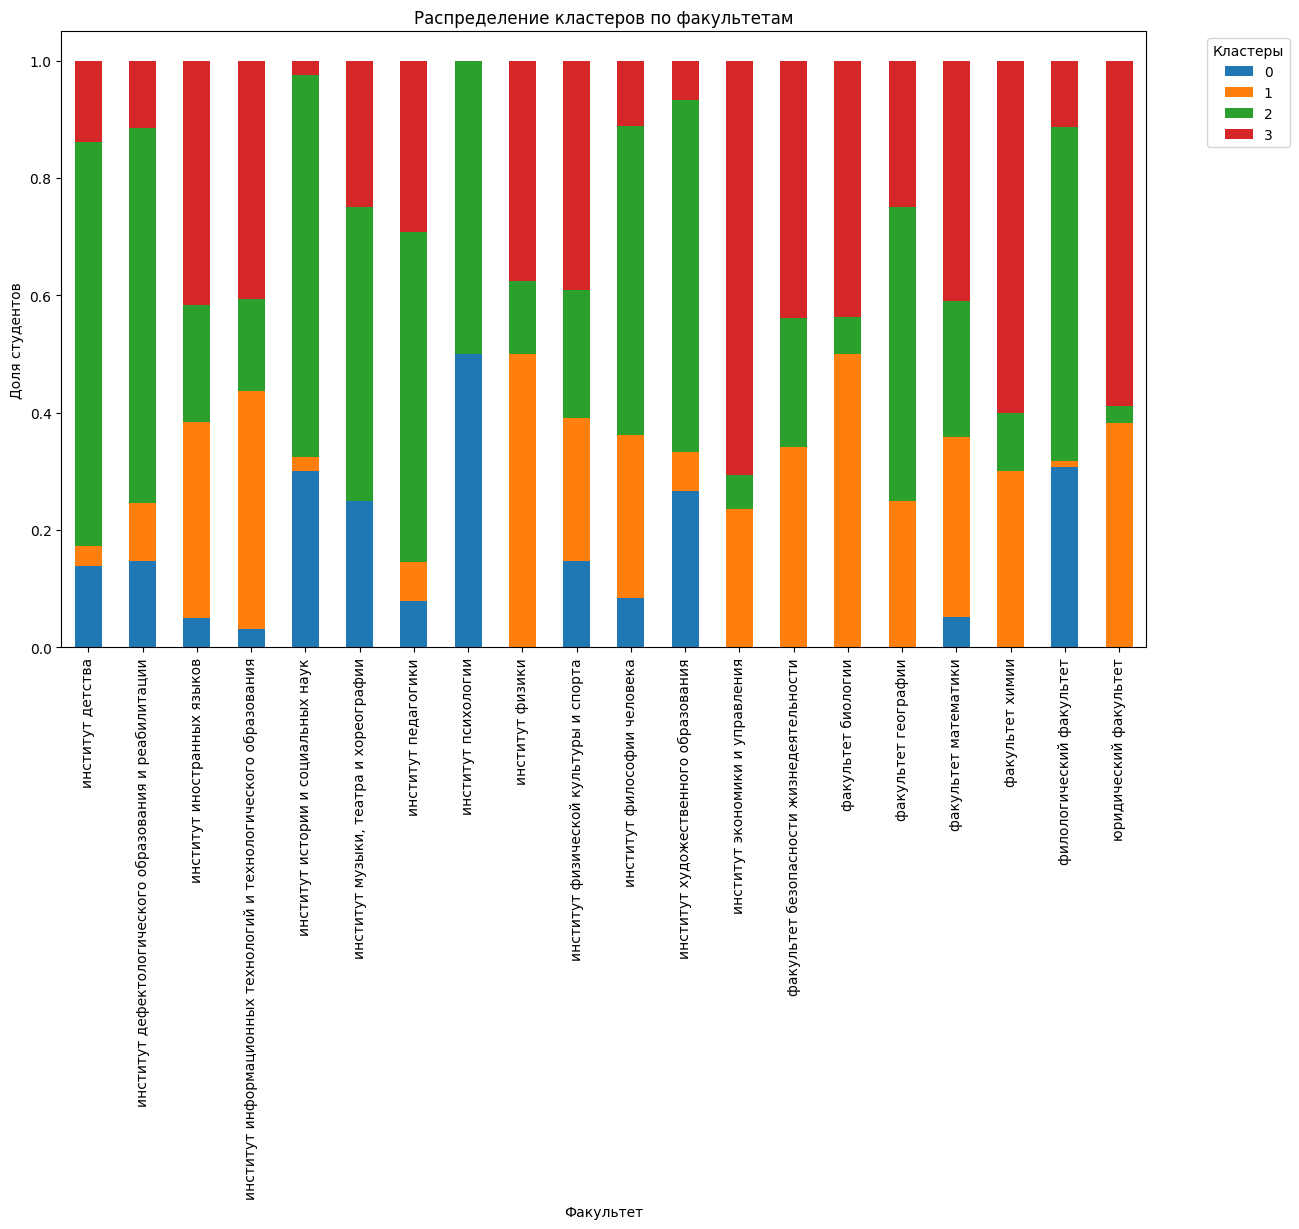

In [71]:
faculty_cluster = pd.crosstab(
    df_filled['На каком факультете/в каком институте Вы обучаетесь?'], 
    df_filled['Cluster'],
    normalize='index'
)

faculty_cluster.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title("Распределение кластеров по факультетам")
plt.ylabel("Доля студентов")
plt.xlabel("Факультет")
plt.legend(title='Кластеры', bbox_to_anchor=(1.05, 1))
plt.show()

### 7. Выводы

####  Профили студентов
**Кластер 0: "Цифровые энтузиасты"**
- Активно используют все электронные платформы
- Высокая потребность в автоматизированных системах мониторинга
- Предпочитают цифровую рефлексию и обратную связь
- Требуют переработки материалов под цифровой формат
- *Рекомендации:* Развитие цифровой экосистемы, автоматизация процессов

**Кластер 1: "Прагматики организации"**
- Акцент на организованном взаимодействии
- Высокая потребность в структурированных материалах
- Важность рефлексии и обратной связи
- Умеренное использование технологий
- *Рекомендации:* Четкие схемы взаимодействия, структурированные программы

**Кластер 2: "Традиционалисты"**
- Низкая потребность в цифровых инструментах
- Предпочитают личное взаимодействие
- Минимальный интерес к автоматизации
- Консервативное отношение к материалам
- *Рекомендации:* Поддержка очных форматов, фокус на личном общении

**Кластер 3: "Автономные практики"**
- Высокая потребность в практико-ориентированных материалах
- Акцент на самостоятельной работе
- Минимальное взаимодействие
- Умеренный интерес к рефлексии
- *Рекомендации:* Практические кейсы, самостоятельные проекты

#### Ключевые рекомендации университету:
1. **Дифференциация форматов обучения:**
   - Для экономического факультета: усилить цифровые компоненты
   - Для технических специальностей: структурированные программы с практическими заданиями
   - Для гуманитарных направлений: поддержка традиционных форматов с элементами самостоятельной работы

2. **Разработка адаптивных материалов:**
   - Создать 4 версии ключевых курсов под разные профили студентов
   - Внедрить систему выбора формата обучения

3. **Оптимизация образовательных платформ:**
   - Разработать модульную систему (цифровые инструменты для Кластера 0, структурированные материалы для Кластера 1)
   - Внедрить гибридные форматы для Кластеров 2 и 3

4. **Система поддержки:**
   - Целевые программы для "Традиционалистов" (адаптация к цифровой среде)
   - Проектные группы для "Автономных практиков"
   - Цифровые наставники для "Цифровых энтузиастов"
